# ANALISIS DE DATOS PARA LAS CASOS DE COVID EN GUATEMALA EN 2020
---

El presente análisis se basa en un proceso de Extracción, Transformación y Carga (ETL) diseñado para procesar datos relacionados con el impacto del COVID-19 en Guatemala durante el año 2020. Este proceso comenzó con la extracción de datos de múltiples fuentes, incluyendo un archivo de casos globales y un conjunto de datos municipales, que proporcionan una perspectiva tanto nacional como local. Posteriormente, se llevaron a cabo diversas transformaciones, como la limpieza de valores atípicos, la normalización de formatos de fecha y la consolidación de métricas clave, asegurando la calidad y coherencia de la información. Finalmente, los datos fueron estructurados y cargados en un entorno analítico, lo que permitió realizar exploraciones detalladas, identificar patrones relevantes y extraer conclusiones que apoyan la toma de decisiones en salud pública. Este enfoque integral garantiza que el análisis esté fundamentado en datos confiables y procesados de manera eficiente.


1. Proceso de Análisis

Carga y Limpieza de Datos:

Archivo Nacional (global_calificacion):
1. Se filtraron los datos para el año 2020.
2. Se eliminaron columnas no relevantes: Country_code, Country, WHO_region.
3. Se corrigieron tipos de datos y se manejaron valores nulos en columnas numéricas como New_cases y New_deaths.
4. Archivo Municipal (municipio.csv):
5. Se eliminaron registros inválidos:
6. codigo_departamento = 9999.
7. codigo_municipio = 0.
8. poblacion <= 0.
9. Se transformaron las columnas de fechas en filas para obtener una estructura más manejable.
10. Se filtraron los datos para incluir únicamente registros del año 2020.

## Análisis de Datos:

**Municipios con Nuevas Muertes:**

* Se agruparon los datos por municipio para calcular el total de nuevas muertes y relacionarlo con la población.
* Relación entre Población y Nuevas Muertes:
* Se analizó cómo los municipios con mayor población tienden a registrar más nuevas muertes.
Visualización de Datos:

**Se generaron dos gráficas clave:**

* Gráfico de Barras: Mostrando los municipios con mayores nuevas muertes.
* Gráfico de Dispersión: Relacionando población con nuevas muertes.

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency


# Configuración de la base de datos (no se utiliza en este código, pero se deja por contexto)
db_config = {
    "host": "database-1.cdwk6mkwcp16.us-east-2.rds.amazonaws.com",
    "user": "admin",
    "password": "m2LakR3hb8iiQjLyttOp",
    "database": "guatemala_casos"
}


# String de conexión para SQLAlchemy
string_connection = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"


# EDA monovariable

## POBLACION POR MUNICIPIO

El análisis monovariable de la población de los municipios se centra exclusivamente en esta variable, evaluando su distribución mediante estadísticas descriptivas como el promedio, la desviación estándar, los valores mínimo y máximo, y los cuartiles. Se elimina cualquier registro nulo para asegurar la consistencia de los datos. Además, se visualiza la distribución con un histograma para identificar patrones y tendencias generales, mientras que un diagrama de caja revela la dispersión y posibles valores atípicos en las poblaciones municipales. Este análisis proporciona una visión clara de cómo varían las poblaciones entre los municipios.

In [ ]:
# Query para obtener datos necesarios solo de la población de los municipios
query = """
SELECT
    municipio.poblacion
FROM municipio;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos para la población
descriptive_stats = data['poblacion'].describe()
print("Estadísticos descriptivos para la población:")
print(descriptive_stats)

Estadísticos descriptivos para la población:
count    2.700000e+02
mean     5.585784e+04
std      8.961198e+04
min      2.563000e+03
25%      2.025850e+04
50%      3.626300e+04
75%      6.388300e+04
max      1.205668e+06
Name: poblacion, dtype: float64


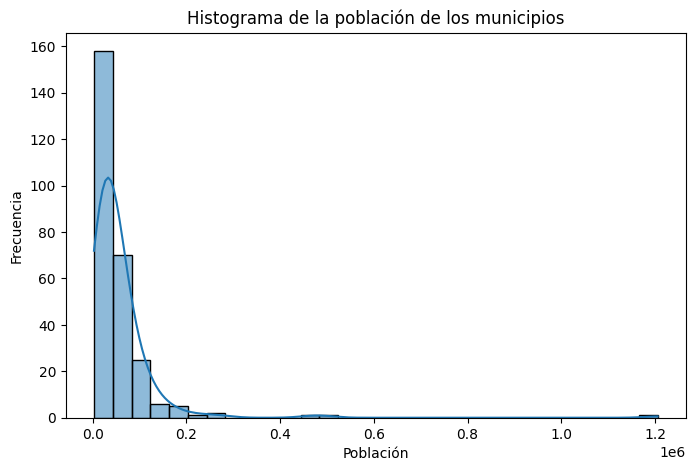

In [ ]:
# Crear histograma para la población
plt.figure(figsize=(8, 5))
sns.histplot(data['poblacion'], kde=True, bins=30)
plt.title("Histograma de la población de los municipios")
plt.xlabel("Población")
plt.ylabel("Frecuencia")
plt.show()


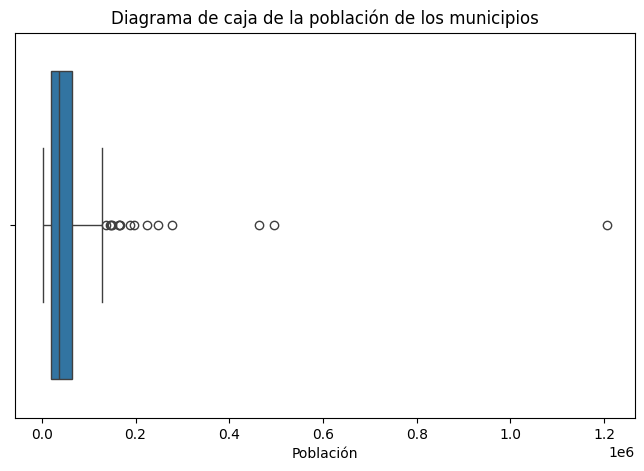

In [ ]:
# Crear diagrama de caja para la población
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['poblacion'])
plt.title("Diagrama de caja de la población de los municipios")
plt.xlabel("Población")
plt.show()



In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    municipio.municipio,
    municipio.poblacion
FROM municipio;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos
descriptive_stats = data['poblacion'].describe()
print(descriptive_stats)


count    2.700000e+02
mean     5.585784e+04
std      8.961198e+04
min      2.563000e+03
25%      2.025850e+04
50%      3.626300e+04
75%      6.388300e+04
max      1.205668e+06
Name: poblacion, dtype: float64


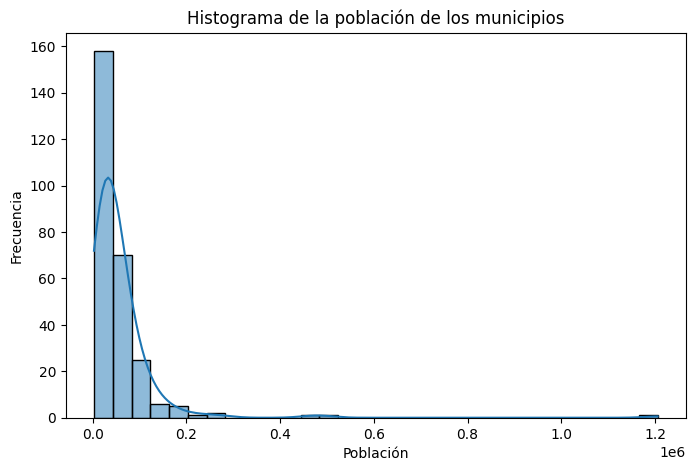

In [ ]:
# Crear histograma
plt.figure(figsize=(8, 5))
sns.histplot(data['poblacion'], kde=True, bins=30)
plt.title("Histograma de la población de los municipios")
plt.xlabel("Población")
plt.ylabel("Frecuencia")
plt.show()


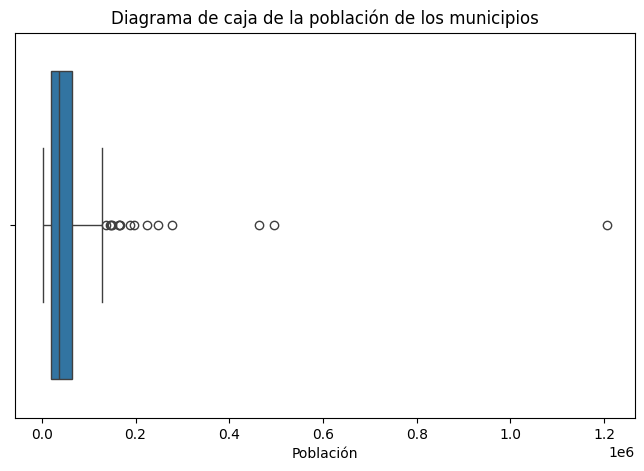

In [ ]:

# Crear diagrama de caja
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['poblacion'])
plt.title("Diagrama de caja de la población de los municipios")
plt.xlabel("Población")
plt.show()


## MUERTES POR MUNICIPIO

El análisis monovariable de las nuevas muertes por municipio se centra en evaluar la distribución de esta variable, calculando estadísticas descriptivas como promedio, desviación estándar, valores mínimos, máximos y cuartiles. Se eliminan los registros con valores nulos para asegurar la consistencia de los datos. Además, se visualiza la frecuencia de las nuevas muertes mediante un histograma, permitiendo identificar tendencias generales, mientras que el diagrama de caja muestra la dispersión y posibles valores atípicos. Este análisis brinda una visión clara de la variabilidad y el impacto de las nuevas muertes a nivel municipal.

In [ ]:
# Query para obtener datos necesarios solo de las nuevas muertes por municipio
query = """
SELECT
    reporte_nacional.New_deaths AS nuevas_muertes
FROM municipio
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos para las nuevas muertes
descriptive_stats = data['nuevas_muertes'].describe()
print("Estadísticos descriptivos para las nuevas muertes:")
print(descriptive_stats)


Estadísticos descriptivos para las nuevas muertes:
count    2186.000000
mean       24.561757
std        15.088028
min         0.000000
25%        14.000000
50%        22.000000
75%        34.000000
max        61.000000
Name: nuevas_muertes, dtype: float64


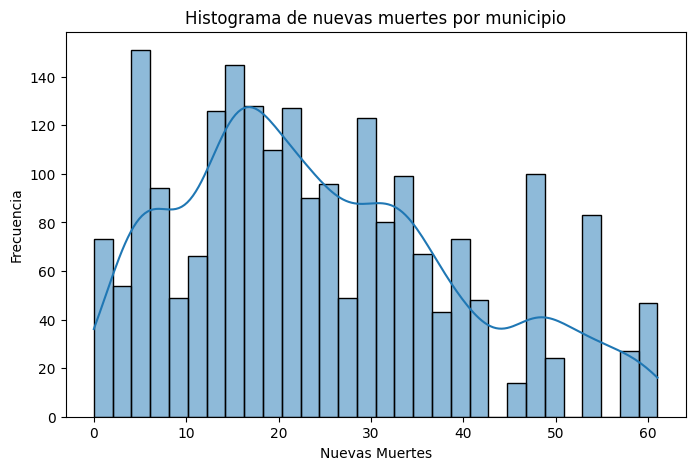

In [ ]:
# Crear histograma para las nuevas muertes
plt.figure(figsize=(8, 5))
sns.histplot(data['nuevas_muertes'], kde=True, bins=30)
plt.title("Histograma de nuevas muertes por municipio")
plt.xlabel("Nuevas Muertes")
plt.ylabel("Frecuencia")
plt.show()

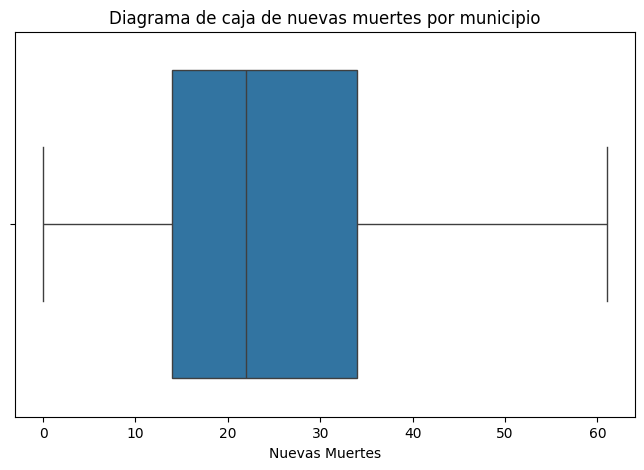

In [ ]:
# Crear diagrama de caja para las nuevas muertes
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['nuevas_muertes'])
plt.title("Diagrama de caja de nuevas muertes por municipio")
plt.xlabel("Nuevas Muertes")
plt.show()

## MUERTES ACUMULADAS

El análisis monovariable de las muertes acumuladas por municipio examina esta variable mediante el cálculo de estadísticas descriptivas, como el promedio, la desviación estándar, los valores mínimo y máximo, y los cuartiles. Los valores nulos se eliminan para garantizar que los resultados sean consistentes. Se utiliza un histograma para visualizar la distribución general de las muertes acumuladas entre los municipios, identificando patrones y frecuencias predominantes. Además, un diagrama de caja muestra la dispersión de los datos y destaca posibles valores atípicos. Este análisis permite comprender mejor la variabilidad y el impacto total de las muertes a nivel municipal.

In [ ]:
# Query para obtener datos necesarios solo de las muertes acumuladas por municipio
query = """
SELECT
    reporte_nacional.Cumulative_deaths AS muertes_acumuladas
FROM municipio
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos para las muertes acumuladas
descriptive_stats = data['muertes_acumuladas'].describe()
print("Estadísticos descriptivos para las muertes acumuladas:")
print(descriptive_stats)


Estadísticos descriptivos para las muertes acumuladas:
count    2186.000000
mean     2368.462031
std      1334.039482
min         0.000000
25%      1404.000000
50%      2506.000000
75%      3453.000000
max      4803.000000
Name: muertes_acumuladas, dtype: float64


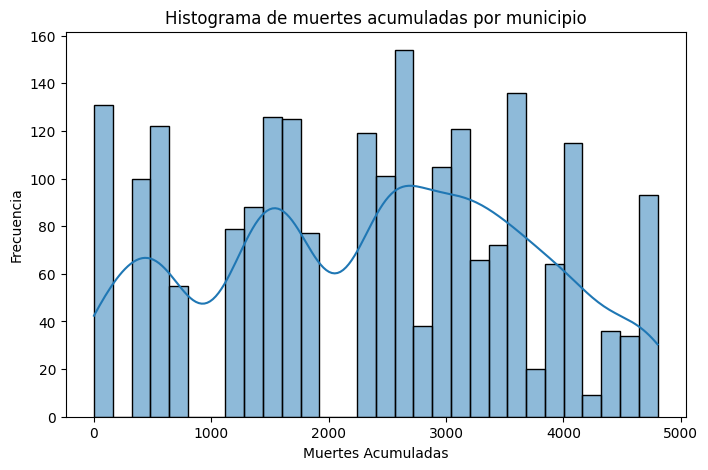

In [ ]:
# Crear histograma para las muertes acumuladas
plt.figure(figsize=(8, 5))
sns.histplot(data['muertes_acumuladas'], kde=True, bins=30)
plt.title("Histograma de muertes acumuladas por municipio")
plt.xlabel("Muertes Acumuladas")
plt.ylabel("Frecuencia")
plt.show()

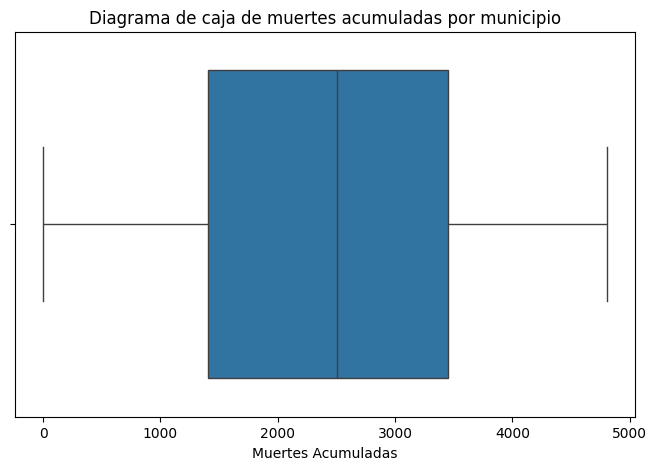

In [ ]:
# Crear diagrama de caja para las muertes acumuladas
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['muertes_acumuladas'])
plt.title("Diagrama de caja de muertes acumuladas por municipio")
plt.xlabel("Muertes Acumuladas")
plt.show()

## MANEJO DE OUTLIERS POBLACION


El análisis de outliers para la población por municipio utiliza el rango intercuartílico (IQR) para identificar y eliminar valores atípicos que podrían distorsionar el análisis. Primero, se obtienen los datos de población desde la base de datos y se eliminan registros nulos.

Estadísticos descriptivos para la población:
count    2.700000e+02
mean     5.585784e+04
std      8.961198e+04
min      2.563000e+03
25%      2.025850e+04
50%      3.626300e+04
75%      6.388300e+04
max      1.205668e+06
Name: poblacion, dtype: float64


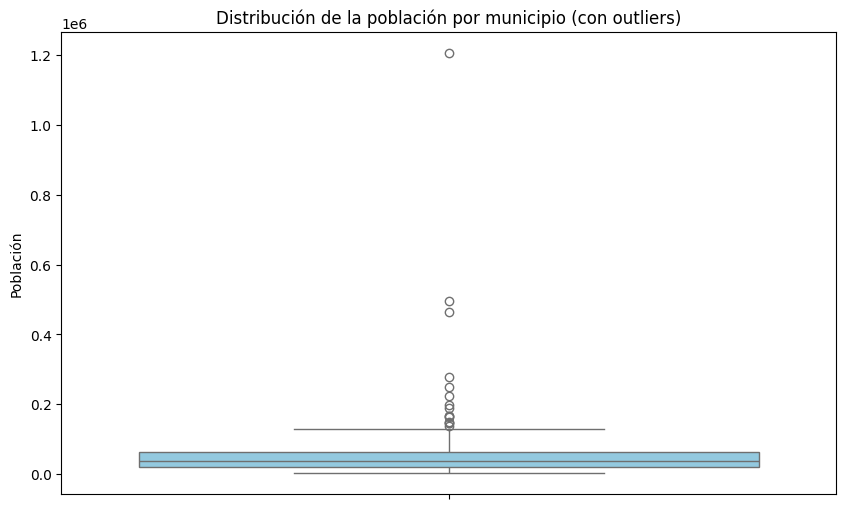

In [ ]:
# Query para obtener datos necesarios solo de la población de los municipios
query = """
SELECT
    municipio.poblacion
FROM municipio;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos para la población
descriptive_stats = data['poblacion'].describe()
print("Estadísticos descriptivos para la población:")
print(descriptive_stats)

# Función para eliminar outliers
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar los datos dentro de los límites
    df_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

    return df_sin_outliers

# Eliminar outliers de la población
data_limpiada = eliminar_outliers(data, 'poblacion')

# Boxplot para la población original y limpia
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, y='poblacion', color='skyblue')
plt.title("Distribución de la población por municipio (con outliers)")
plt.ylabel("Población")
plt.show()

Luego, se calculan los límites inferior y superior basados en el IQR, y se filtran las poblaciones que están fuera de estos rangos. Finalmente, se visualizan los resultados mediante diagramas de caja (boxplots) que muestran la distribución original con outliers y la distribución limpia sin ellos, permitiendo comparar cómo los valores extremos afectan la variabilidad de los datos.

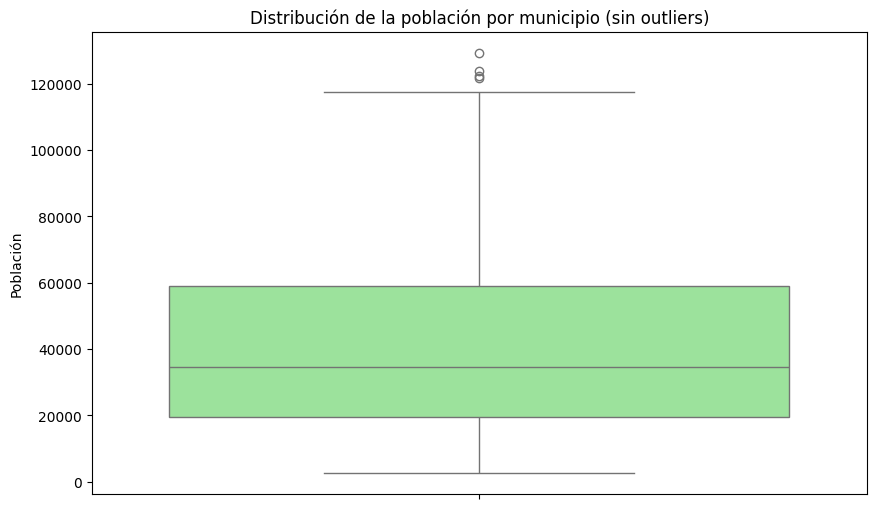

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_limpiada, y='poblacion', color='lightgreen')
plt.title("Distribución de la población por municipio (sin outliers)")
plt.ylabel("Población")
plt.show()

## MANEJO DE OUTLIERS NUEVAS MUERTES

El análisis de outliers para las nuevas muertes por municipio identifica valores atípicos utilizando el rango intercuartílico (IQR).

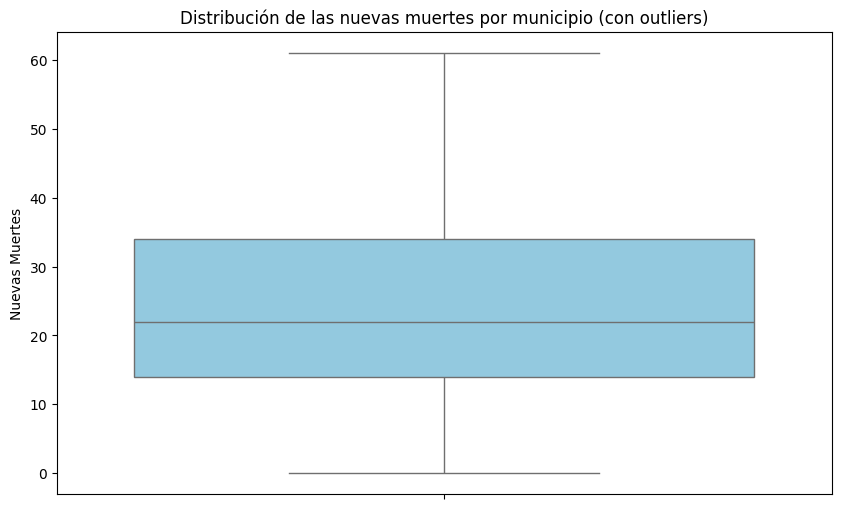

In [ ]:
# Query para obtener datos necesarios solo de las nuevas muertes por municipio
query = """
SELECT
    reporte_nacional.New_deaths AS nuevas_muertes
FROM municipio
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Función para eliminar outliers
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar los datos dentro de los límites
    df_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

    return df_sin_outliers

# Eliminar outliers de las nuevas muertes
data_limpiada = eliminar_outliers(data, 'nuevas_muertes')

# Boxplot para las nuevas muertes (original y limpia)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, y='nuevas_muertes', color='skyblue')
plt.title("Distribución de las nuevas muertes por municipio (con outliers)")
plt.ylabel("Nuevas Muertes")
plt.show()


Después de obtener los datos desde la base de datos y eliminar valores nulos, se calculan los límites inferior y superior con base en los cuartiles para filtrar los valores que están fuera de este rango. Se generan estadísticas descriptivas para entender la distribución inicial y, posteriormente, se visualizan los datos mediante diagramas de caja. El primer boxplot muestra la distribución original con outliers, mientras que el segundo representa los datos limpios sin ellos, permitiendo analizar la variabilidad y eliminar el efecto de valores extremos.

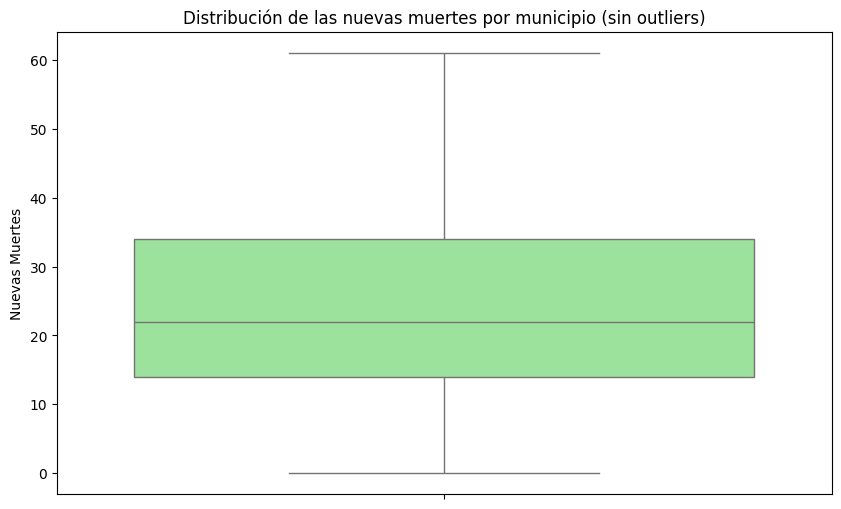

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_limpiada, y='nuevas_muertes', color='lightgreen')
plt.title("Distribución de las nuevas muertes por municipio (sin outliers)")
plt.ylabel("Nuevas Muertes")
plt.show()

MANEJO DE OUTLIERS MUERTES ACUMULADAS



In [ ]:
# Query para obtener datos necesarios solo de las muertes acumuladas por municipio
query = """
SELECT
    reporte_nacional.Cumulative_deaths AS muertes_acumuladas
FROM municipio
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos para las muertes acumuladas
descriptive_stats = data['muertes_acumuladas'].describe()
print("Estadísticos descriptivos para las muertes acumuladas:")
print(descriptive_stats)




Estadísticos descriptivos para las muertes acumuladas:
count    2186.000000
mean     2368.462031
std      1334.039482
min         0.000000
25%      1404.000000
50%      2506.000000
75%      3453.000000
max      4803.000000
Name: muertes_acumuladas, dtype: float64


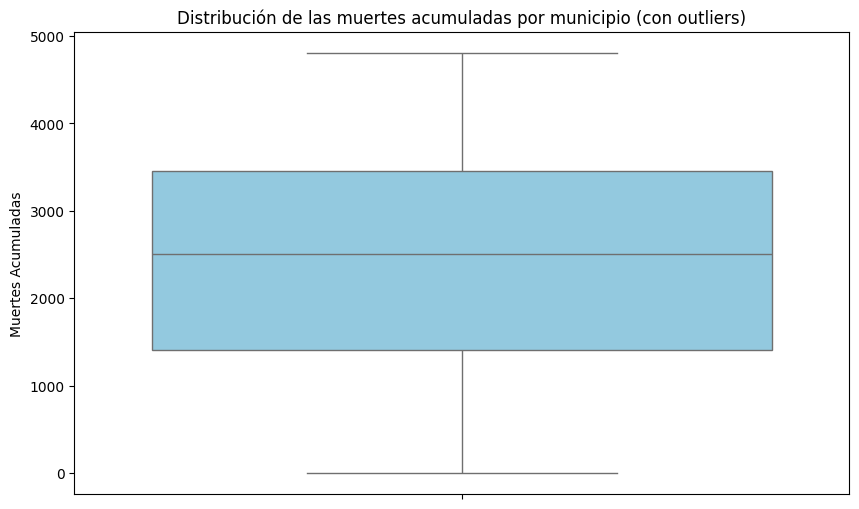

In [ ]:
# Función para eliminar outliers
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar los datos dentro de los límites
    df_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

    return df_sin_outliers

# Eliminar outliers de las muertes acumuladas
data_limpiada = eliminar_outliers(data, 'muertes_acumuladas')

# Boxplot para las muertes acumuladas (original y limpia)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, y='muertes_acumuladas', color='skyblue')
plt.title("Distribución de las muertes acumuladas por municipio (con outliers)")
plt.ylabel("Muertes Acumuladas")
plt.show()

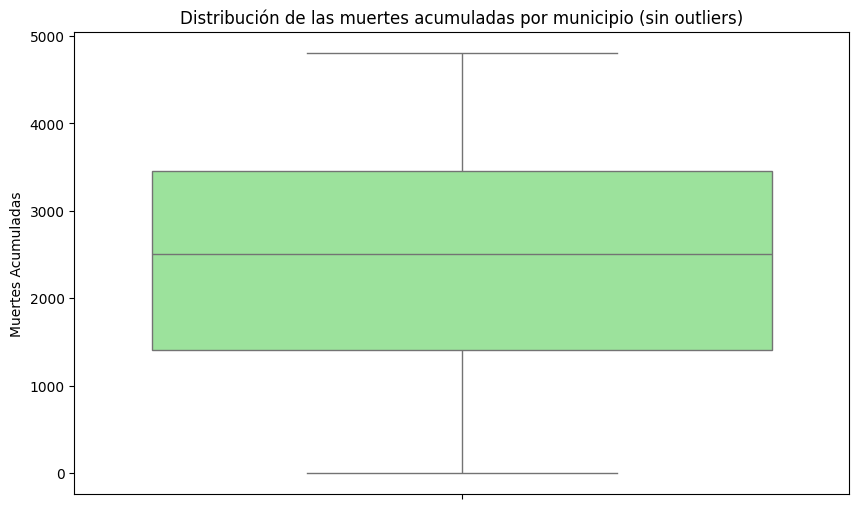

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_limpiada, y='muertes_acumuladas', color='lightgreen')
plt.title("Distribución de las muertes acumuladas por municipio (sin outliers)")
plt.ylabel("Muertes Acumuladas")
plt.show()


## ANALISIS EDA MONOVARIABLE DE DATOS CUALITATIVOS

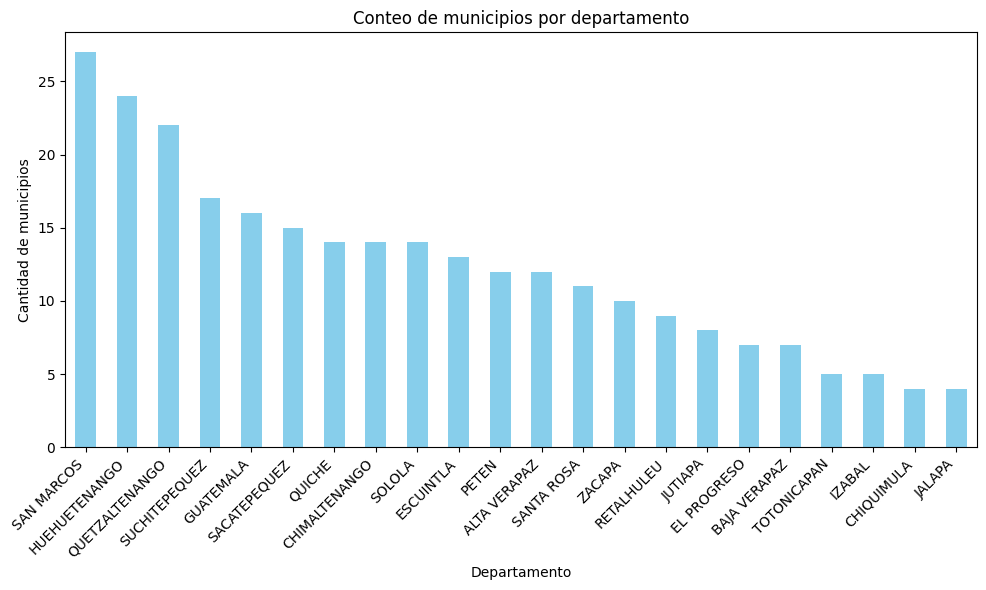

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    departamento.departamento,
    municipio.municipio
FROM municipio
JOIN departamento ON municipio.codigo_departamento = departamento.codigo_departamento;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Contar registros por departamento y municipio
department_counts = data['departamento'].value_counts()
municipality_counts = data['municipio'].value_counts()

# Crear diagrama de barras para el conteo de registros por departamento
plt.figure(figsize=(10, 6))
department_counts.plot(kind='bar', color='skyblue')
plt.title("Conteo de municipios por departamento")
plt.xlabel("Departamento")
plt.ylabel("Cantidad de municipios")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

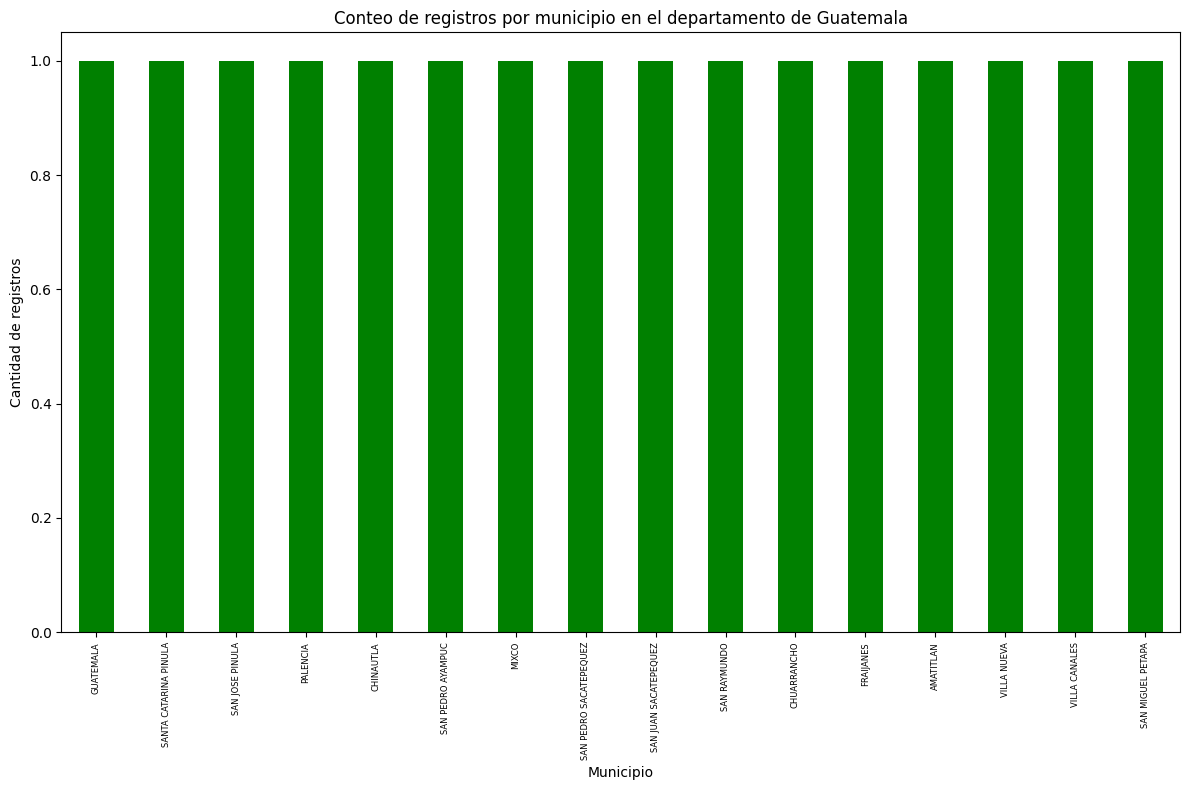

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    departamento.departamento,
    municipio.municipio
FROM municipio
JOIN departamento ON municipio.codigo_departamento = departamento.codigo_departamento
WHERE departamento.departamento = 'Guatemala';
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Contar registros por municipio en el departamento de Guatemala
municipality_counts_guatemala = data['municipio'].value_counts()

# Crear diagrama de barras para el conteo de registros por municipio en el departamento de Guatemala
if not municipality_counts_guatemala.empty:
    plt.figure(figsize=(12, 8))
    municipality_counts_guatemala.plot(kind='bar', color='green')
    plt.title("Conteo de registros por municipio en el departamento de Guatemala")
    plt.xlabel("Municipio")
    plt.ylabel("Cantidad de registros")
    plt.xticks(rotation=90, fontsize=6)
    plt.tight_layout()
    plt.show()
else:
    print("No hay registros disponibles para el departamento de Guatemala.")

# EDA MULTIVARIABLE

El análisis multivariable busca explorar la relación entre varias variables, como la población, las nuevas muertes y las muertes acumuladas por municipio. Este tipo de análisis combina las perspectivas de diferentes variables para identificar patrones, correlaciones o comportamientos inusuales entre ellas. Por ejemplo, se puede investigar si los municipios con mayor población tienen una mayor cantidad de muertes acumuladas o si existe algún patrón regional. La visualización de estos datos podría incluir diagramas de dispersión, mapas de calor o gráficos de correlación que ayuden a comprender cómo estas variables interactúan y afectan entre sí. Este enfoque proporciona una visión más completa y detallada del comportamiento de los datos.

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    municipio.municipio,
    municipio.poblacion,
    reporte_nacional.New_deaths AS nuevas_muertes
FROM municipio
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported
WHERE municipio.codigo_departamento = (
    SELECT codigo_departamento FROM departamento WHERE departamento = 'Guatemala'
);
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Estadísticos descriptivos
descriptive_stats = data[['poblacion', 'nuevas_muertes']].describe()
print(descriptive_stats)


          poblacion  nuevas_muertes
count  5.930000e+02      593.000000
mean   5.181762e+05       23.042159
std    4.256241e+05       15.191789
min    1.795700e+04        0.000000
25%    1.476040e+05       12.000000
50%    4.645280e+05       20.000000
75%    4.945610e+05       34.000000
max    1.205668e+06       61.000000


# MUNICIPIOS Y LA CANTIDAD DE NUEVAS MUERTES

El análisis de dispersión entre los municipios y la cantidad de nuevas muertes para el departamento de Guatemala revela cómo se distribuyen las muertes recientes entre las localidades. Cada punto en el gráfico representa un municipio, con el tamaño y color del punto indicando la magnitud de las nuevas muertes.

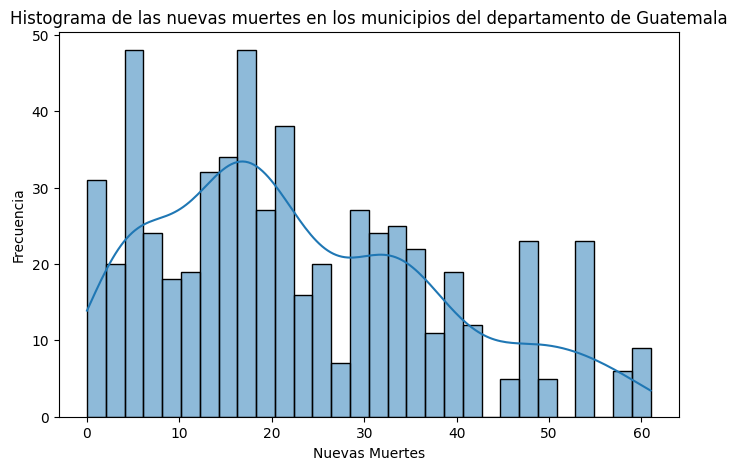

In [ ]:
# Crear histograma de nuevas muertes
plt.figure(figsize=(8, 5))
sns.histplot(data['nuevas_muertes'], kde=True, bins=30)
plt.title("Histograma de las nuevas muertes en los municipios del departamento de Guatemala")
plt.xlabel("Nuevas Muertes")
plt.ylabel("Frecuencia")
plt.show()



Esto permite identificar visualmente los municipios más afectados, destacando aquellos con mayores tasas de mortalidad reciente. La rotación y reducción del tamaño de las etiquetas de los municipios garantizan una mejor lectura, facilitando la interpretación del impacto a nivel local. Este análisis es útil para priorizar recursos y estrategias en los municipios más afectados.

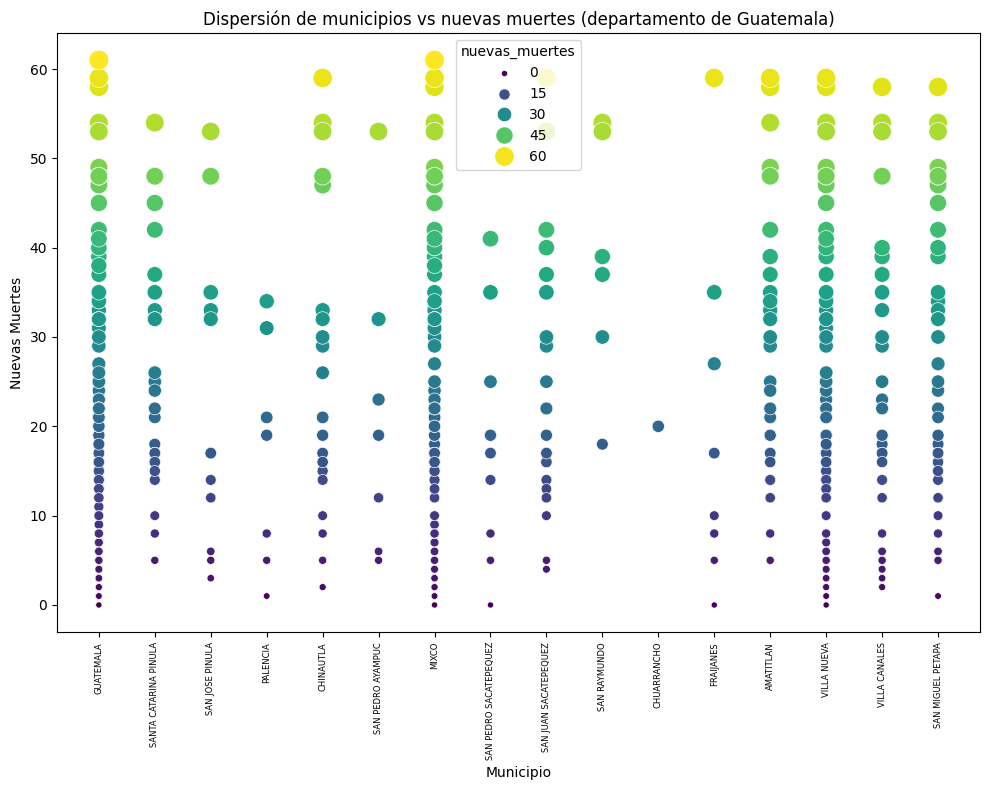

In [ ]:
# Crear gráfico de dispersión entre municipios y nuevas muertes
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='municipio', y='nuevas_muertes', hue='nuevas_muertes', palette='viridis', size='nuevas_muertes', sizes=(20, 200))
plt.title("Dispersión de municipios vs nuevas muertes (departamento de Guatemala)")
plt.xlabel("Municipio")
plt.ylabel("Nuevas Muertes")
plt.xticks(rotation=90, fontsize=6)  # Ajustar nombres de municipios para mejor visualización
plt.tight_layout()
plt.show()

# La matriz de correlaciones de Pearson

Esto muestra que la relación entre la población y las nuevas muertes es débilmente negativa, con un valor de -0.11. Esto indica que no hay una relación lineal significativa entre ambas variables, lo que sugiere que un mayor número de habitantes en un municipio no está directamente asociado con un aumento o disminución en las nuevas muertes. Este resultado destaca la necesidad de considerar otros factores para entender mejor el impacto de las muertes en los municipios.



In [ ]:
# Matriz de correlaciones de Pearson
pearson_corr = data[['poblacion', 'nuevas_muertes']].corr(method='pearson')
print("Matriz de correlaciones de Pearson:\n", pearson_corr)

Matriz de correlaciones de Pearson:
                 poblacion  nuevas_muertes
poblacion        1.000000       -0.111072
nuevas_muertes  -0.111072        1.000000


# La matriz de correlaciones de Spearman

Esto indica que la relación entre la población y las nuevas muertes es débilmente negativa, con un valor de -0.11. Este coeficiente mide la asociación entre los rangos de las variables en lugar de sus valores absolutos, lo que sugiere que no existe una relación significativa entre los municipios más poblados y el número de nuevas muertes. Esto refuerza la idea de que otros factores, más allá de la población, podrían estar influyendo en las cifras de mortalidad.

In [ ]:
# Matriz de correlaciones de Spearman
spearman_corr = data[['poblacion', 'nuevas_muertes']].corr(method='spearman')
print("Matriz de correlaciones de Spearman:\n", spearman_corr)


Matriz de correlaciones de Spearman:
                 poblacion  nuevas_muertes
poblacion        1.000000       -0.106598
nuevas_muertes  -0.106598        1.000000


# El coeficiente de correlación de Kendall

Esto muestra que la relación entre la población y las nuevas muertes es débilmente negativa, con un valor de -0.08. Este coeficiente mide la concordancia entre los rangos de las variables, evaluando relaciones no lineales. El resultado indica que no hay una asociación significativa entre los municipios más poblados y el número de nuevas muertes, sugiriendo que factores adicionales, como la distribución de recursos o densidad poblacional, podrían tener mayor influencia en las cifras de mortalidad.

In [ ]:
# Coeficiente de correlación de Kendall
kendall_corr = data[['poblacion', 'nuevas_muertes']].corr(method='kendall')
print("Coeficiente de correlación de Kendall:\n", kendall_corr)

Coeficiente de correlación de Kendall:
                 poblacion  nuevas_muertes
poblacion        1.000000       -0.076724
nuevas_muertes  -0.076724        1.000000


# El mapa de calor de correlaciones de Pearson

Esto representa visualmente las relaciones lineales entre las variables analizadas. En este caso, la correlación entre la población y las nuevas muertes es débilmente negativa, con un valor de -0.11, indicando que no existe una relación lineal significativa entre estas variables. Las tonalidades del gráfico reflejan la intensidad y dirección de la correlación: los colores cercanos al rojo indican correlaciones positivas, mientras que los cercanos al azul indican correlaciones negativas. Este análisis confirma que otros factores más allá de la población podrían estar influyendo en las nuevas muertes.

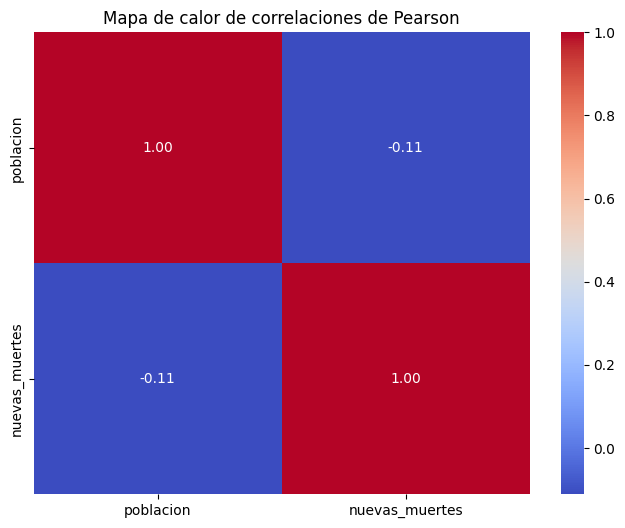

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de calor de correlaciones de Pearson")
plt.show()

# El resultado del test Chi-cuadrado

Analiza la relación entre las variables categóricas "municipio" y "nuevas muertes". El valor obtenido de Chi-cuadrado es 539.01 con un p-valor de 0.9999999913, lo que indica que no hay una asociación estadísticamente significativa entre estas variables. Esto significa que, dentro de este conjunto de datos, la variación en el número de nuevas muertes no parece estar asociada directamente con los diferentes municipios. Este resultado sugiere que otros factores, como densidad poblacional, recursos sanitarios o políticas locales, podrían estar influyendo en las nuevas muertes de manera más significativa.

In [ ]:
from scipy.stats import chi2_contingency

# Test chi-cuadrado (para variables categóricas)
# Convertir 'municipio' a una categoría y calcular chi-cuadrado entre municipio y nuevas muertes
data['municipio_cat'] = data['municipio'].astype('category').cat.codes
chi2, p, dof, ex = chi2_contingency(pd.crosstab(data['municipio_cat'], data['nuevas_muertes'].astype(int)))
print(f"Resultado del test Chi-cuadrado:\nChi2: {chi2}, p-valor: {p}, Grados de libertad: {dof}")

Resultado del test Chi-cuadrado:
Chi2: 539.0144021319951, p-valor: 0.9999999912666148, Grados de libertad: 735


# El análisis de multicolinealidad

mediante el cálculo del Factor de Inflación de la Varianza (VIF) evalúa la correlación entre las variables independientes. En este caso:

* Población y nuevas muertes tienen un VIF cercano a 1.01, lo que indica una ausencia de multicolinealidad entre estas variables. Esto sugiere que no están altamente correlacionadas y pueden incluirse juntas en modelos sin riesgo de redundancia.
* Intercepto tiene un VIF de 5.25, lo cual es esperado porque representa la constante del modelo y no afecta la interpretación de las variables independientes.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Análisis de multicolinealidad
variables = data[['poblacion', 'nuevas_muertes']].copy()  # Solución al SettingWithCopyWarning
variables['intercept'] = 1  # Añadir constante para calcular el VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = variables.columns
vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
print("Análisis de multicolinealidad:\n", vif_data)

Análisis de multicolinealidad:
          Variable       VIF
0       poblacion  1.012491
1  nuevas_muertes  1.012491
2       intercept  5.252470


En general, este análisis confirma que las variables "población" y "nuevas muertes" no presentan problemas de multicolinealidad y pueden ser utilizadas de manera confiable en análisis posteriores, como modelos de regresión.

# DEPARTAMENTOS Y LA CANTIDAD DE NUEVAS MUERTES

El análisis de dispersión entre los departamentos y la cantidad de nuevas muertes proporciona una representación visual del impacto de la mortalidad reciente en cada departamento.

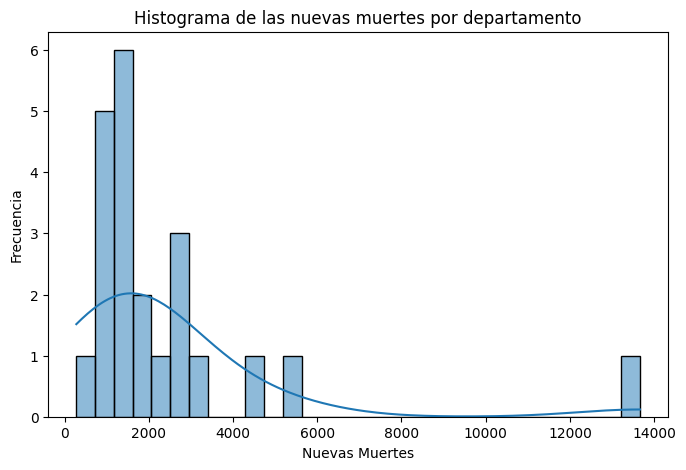

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    departamento.departamento,
    SUM(reporte_nacional.New_deaths) AS nuevas_muertes
FROM departamento
LEFT JOIN municipio ON departamento.codigo_departamento = municipio.codigo_departamento
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported
GROUP BY departamento.departamento;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Crear histograma de nuevas muertes por departamento
plt.figure(figsize=(8, 5))
sns.histplot(data['nuevas_muertes'], kde=True, bins=30)
plt.title("Histograma de las nuevas muertes por departamento")
plt.xlabel("Nuevas Muertes")
plt.ylabel("Frecuencia")
plt.show()


Cada punto en el gráfico representa un departamento, con el tamaño y color de los puntos indicando la magnitud de las nuevas muertes. Los departamentos con mayores cantidades destacan claramente, lo que facilita la identificación de las áreas más afectadas. Además, el histograma complementa este análisis mostrando la distribución general de las nuevas muertes entre los departamentos, ayudando a entender la frecuencia de diferentes niveles de impacto. Este enfoque es valioso para priorizar estrategias de atención a nivel regional.


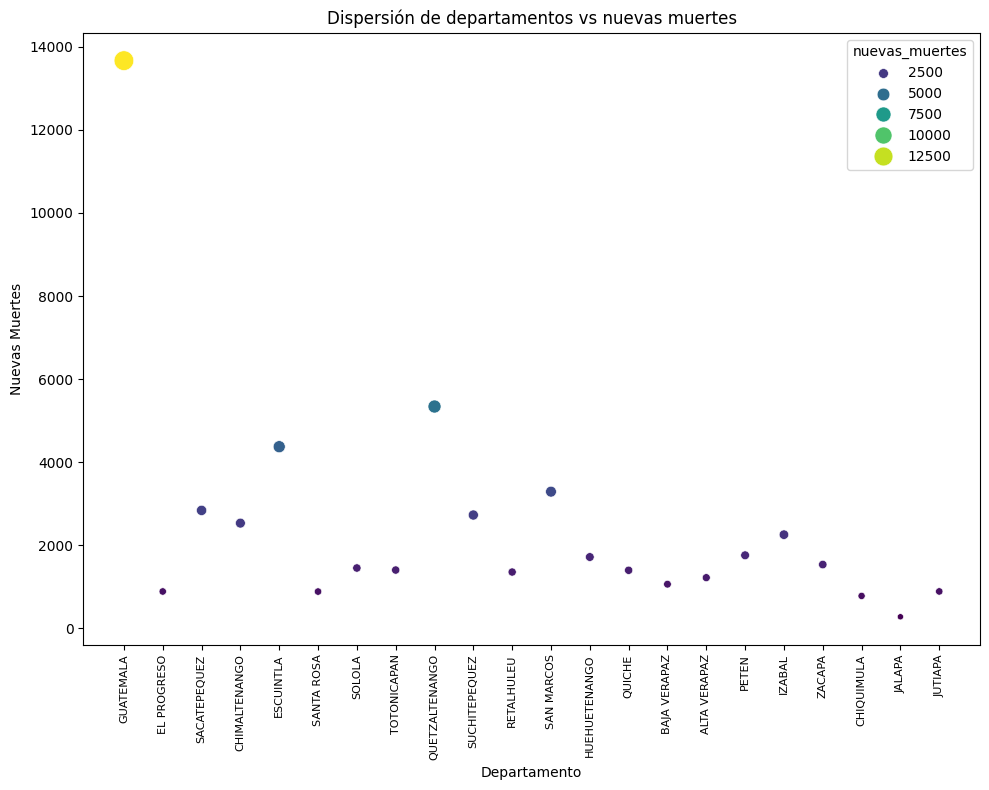

In [ ]:
# Crear gráfico de dispersión entre departamentos y nuevas muertes
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='departamento', y='nuevas_muertes', hue='nuevas_muertes', palette='viridis', size='nuevas_muertes', sizes=(20, 200))
plt.title("Dispersión de departamentos vs nuevas muertes")
plt.xlabel("Departamento")
plt.ylabel("Nuevas Muertes")
plt.xticks(rotation=90, fontsize=8)  # Ajustar nombres de departamentos para mejor visualización
plt.tight_layout()
plt.show()


# MUNICIPIO VS POBLACION
El análisis de dispersión entre municipios y población permite visualizar cómo se distribuye la población entre las distintas localidades.

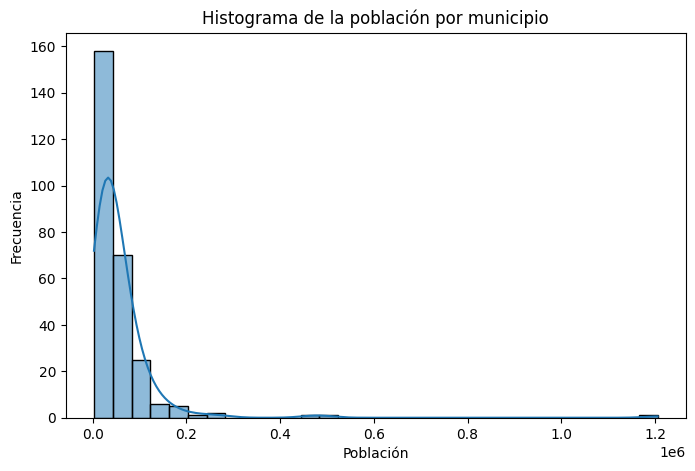

In [ ]:
# Creación del motor SQL
engine = create_engine(string_connection)

# Query para obtener datos necesarios
query = """
SELECT
    municipio.municipio,
    municipio.poblacion
FROM municipio;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Crear histograma de población por municipio
plt.figure(figsize=(8, 5))
sns.histplot(data['poblacion'], kde=True, bins=30)
plt.title("Histograma de la población por municipio")
plt.xlabel("Población")
plt.ylabel("Frecuencia")
plt.show()


 Cada punto en el gráfico representa un municipio, con el tamaño y color del punto indicando el nivel de población. Esto facilita identificar municipios con mayor o menor cantidad de habitantes, ayudando a comprender patrones de densidad poblacional. Además, el histograma complementa este análisis mostrando cómo se distribuyen las poblaciones a lo largo de todos los municipios, identificando posibles concentraciones en ciertos rangos. Este tipo de análisis es clave para el diseño de políticas locales y la asignación de recursos.


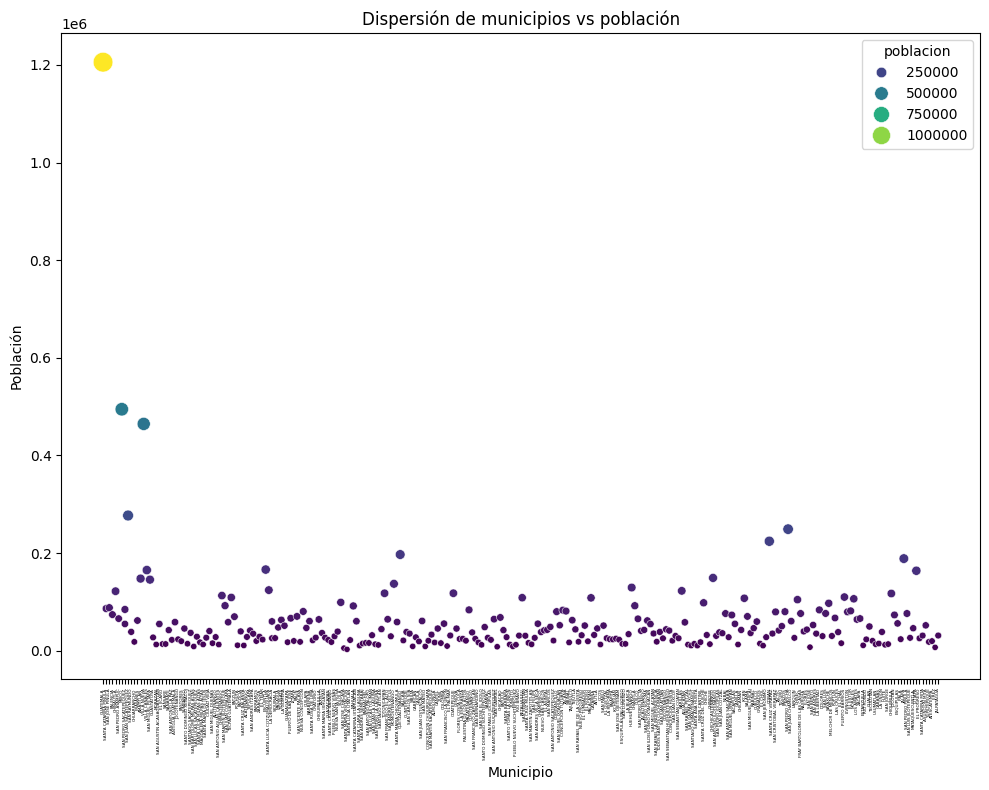

In [ ]:
# Crear gráfico de dispersión entre municipios y población
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='municipio', y='poblacion', hue='poblacion', palette='viridis', size='poblacion', sizes=(20, 200))
plt.title("Dispersión de municipios vs población")
plt.xlabel("Municipio")
plt.ylabel("Población")
plt.xticks(rotation=90, fontsize=3)  # Ajustar nombres de municipios para mejor visualización
plt.tight_layout()
plt.show()


# DEPARTAMENTO VS POBLACION

El análisis de dispersión entre departamentos y población proporciona una visión clara de cómo se distribuye la población en los diferentes departamentos.

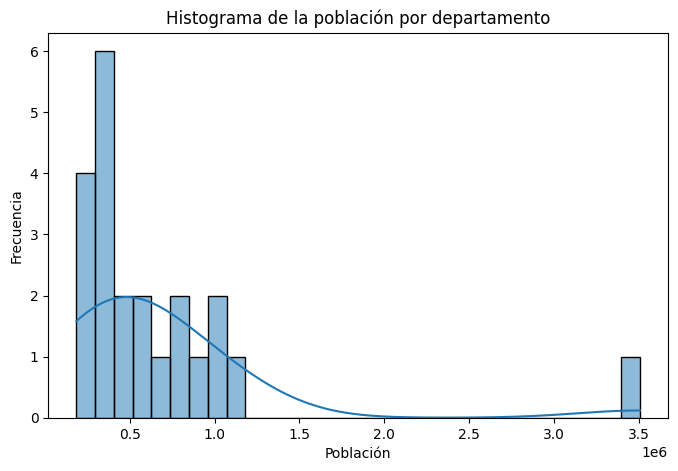

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    departamento.departamento,
    SUM(municipio.poblacion) AS poblacion
FROM departamento
LEFT JOIN municipio ON departamento.codigo_departamento = municipio.codigo_departamento
GROUP BY departamento.departamento;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Crear histograma de población por departamento
plt.figure(figsize=(8, 5))
sns.histplot(data['poblacion'], kde=True, bins=30)
plt.title("Histograma de la población por departamento")
plt.xlabel("Población")
plt.ylabel("Frecuencia")
plt.show()


Cada punto en el gráfico representa un departamento, y el tamaño y color del punto indican la magnitud de su población. Esto facilita la identificación de los departamentos más y menos poblados, permitiendo evaluar posibles disparidades en la distribución de la población. El histograma complementa esta visualización al mostrar la frecuencia de poblaciones dentro de distintos rangos, ayudando a entender mejor la distribución general entre los departamentos. Este análisis es útil para planificar políticas y asignar recursos a nivel regional.

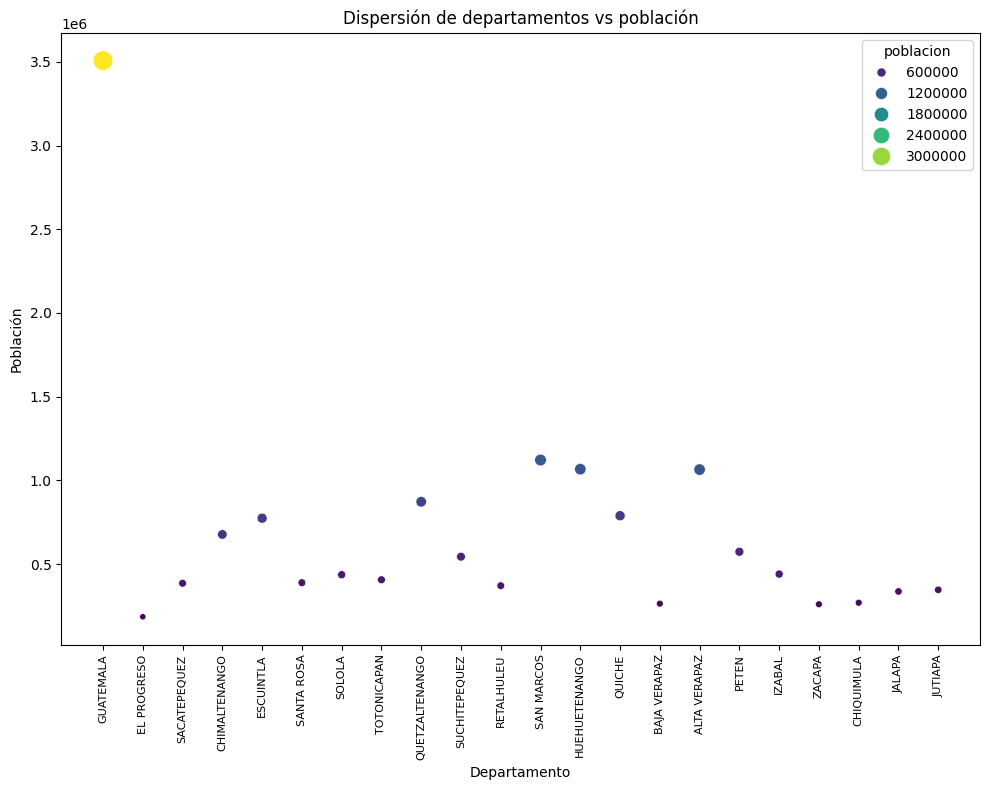

In [ ]:
# Crear gráfico de dispersión entre departamentos y población
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='departamento', y='poblacion', hue='poblacion', palette='viridis', size='poblacion', sizes=(20, 200))
plt.title("Dispersión de departamentos vs población")
plt.xlabel("Departamento")
plt.ylabel("Población")
plt.xticks(rotation=90, fontsize=8)  # Cambiar tamaño de fuente de los departamentos
plt.tight_layout()
plt.show()


# MUNICIPIOS VS CANTIDAD DE MUERTES ACUMULADAS

El análisis de dispersión entre municipios y muertes acumuladas permite visualizar cómo se distribuyen las muertes totales a lo largo de los diferentes municipios. Cada punto en el gráfico representa un municipio, y el tamaño y color del punto indican la magnitud de las muertes acumuladas.

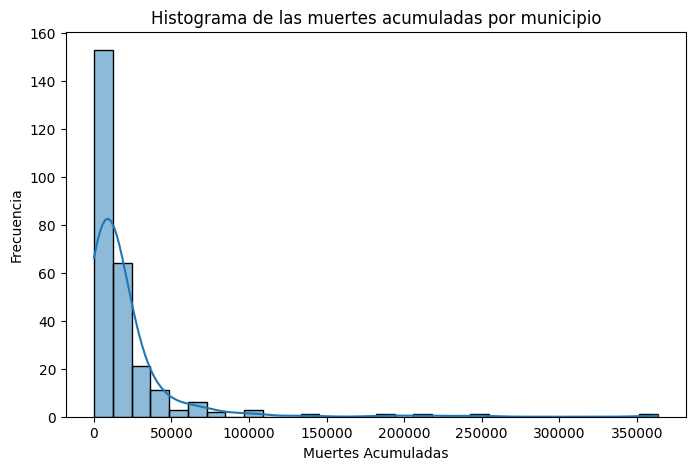

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    municipio.municipio,
    SUM(reporte_nacional.Cumulative_deaths) AS muertes_acumuladas
FROM municipio
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported
GROUP BY municipio.municipio;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Crear histograma de muertes acumuladas por municipio
plt.figure(figsize=(8, 5))
sns.histplot(data['muertes_acumuladas'], kde=True, bins=30)
plt.title("Histograma de las muertes acumuladas por municipio")
plt.xlabel("Muertes Acumuladas")
plt.ylabel("Frecuencia")
plt.show()

Este enfoque ayuda a identificar rápidamente los municipios con mayor impacto, destacando las áreas que podrían requerir mayor atención o recursos. El histograma complementario ofrece una visión de la frecuencia con la que ocurren diferentes niveles de muertes acumuladas, ayudando a identificar patrones generales y posibles outliers en los datos. Este análisis es esencial para la planificación estratégica y la respuesta efectiva.

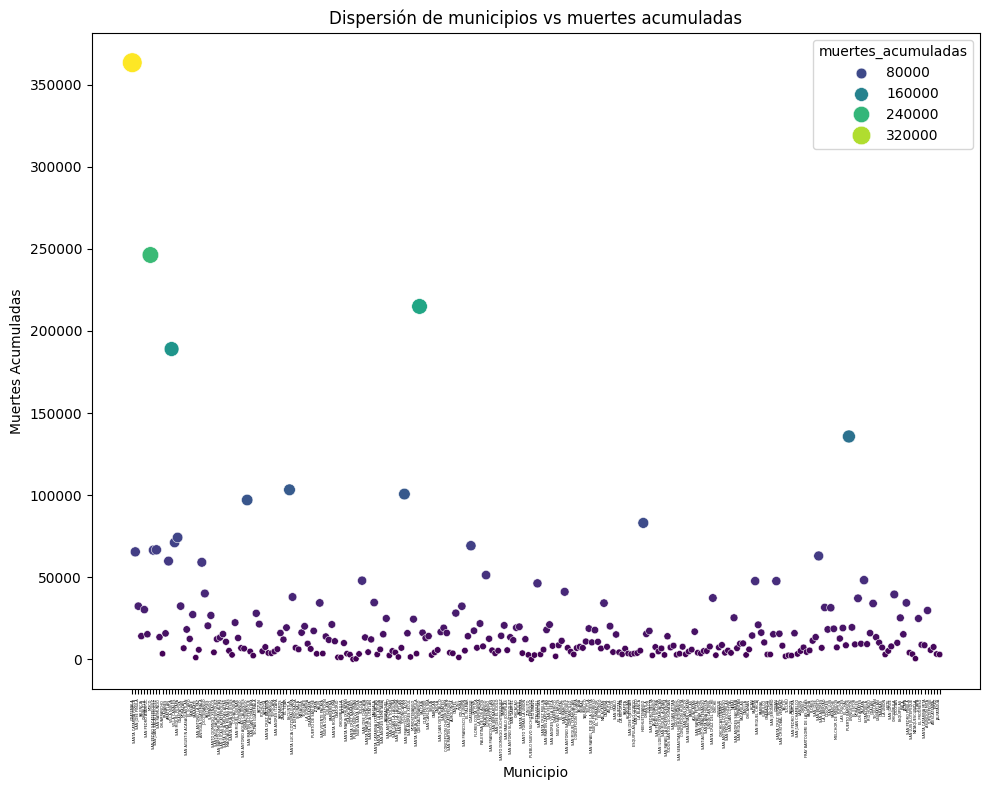

In [ ]:
# Crear gráfico de dispersión entre municipios y muertes acumuladas
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='municipio', y='muertes_acumuladas', hue='muertes_acumuladas', palette='viridis', size='muertes_acumuladas', sizes=(20, 200))
plt.title("Dispersión de municipios vs muertes acumuladas")
plt.xlabel("Municipio")
plt.ylabel("Muertes Acumuladas")
plt.xticks(rotation=90, fontsize=2.5)  # Cambiar tamaño de fuente de los municipios
plt.tight_layout()
plt.show()

# DEPARTAMENTOS VS CANTIDAD DE MUERTES ACUMULADAS

El análisis de dispersión entre departamentos y muertes acumuladas permite observar la distribución del impacto de las muertes totales en los diferentes departamentos.

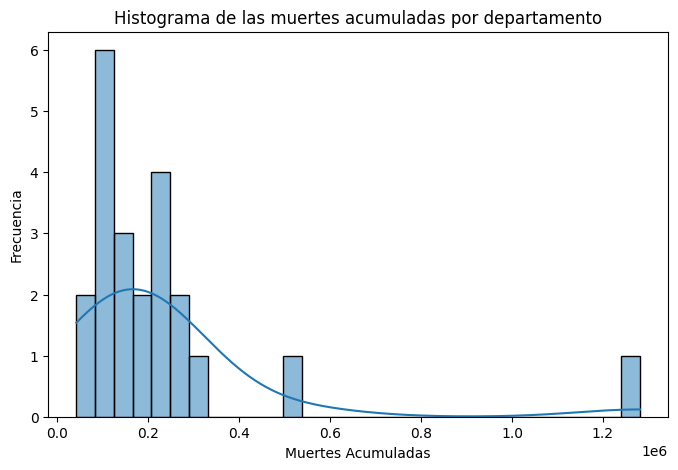

In [ ]:
# Query para obtener datos necesarios
query = """
SELECT
    departamento.departamento,
    SUM(reporte_nacional.Cumulative_deaths) AS muertes_acumuladas
FROM departamento
LEFT JOIN municipio ON departamento.codigo_departamento = municipio.codigo_departamento
LEFT JOIN evento ON municipio.codigo_municipio = evento.codigo_municipio
LEFT JOIN reporte_nacional ON evento.Date_reported = reporte_nacional.Date_reported
GROUP BY departamento.departamento;
"""

# Cargar los datos en un DataFrame
data = pd.read_sql(query, engine)

# Eliminar filas con valores nulos
data = data.dropna()

# Crear histograma de muertes acumuladas por departamento
plt.figure(figsize=(8, 5))
sns.histplot(data['muertes_acumuladas'], kde=True, bins=30)
plt.title("Histograma de las muertes acumuladas por departamento")
plt.xlabel("Muertes Acumuladas")
plt.ylabel("Frecuencia")
plt.show()

Cada punto representa un departamento, con el tamaño y color indicando la magnitud de las muertes acumuladas. Esto facilita la identificación de departamentos más afectados, ayudando en la priorización de recursos. El histograma complementa esta visualización mostrando la frecuencia de valores de muertes acumuladas, permitiendo detectar patrones generales y outliers.

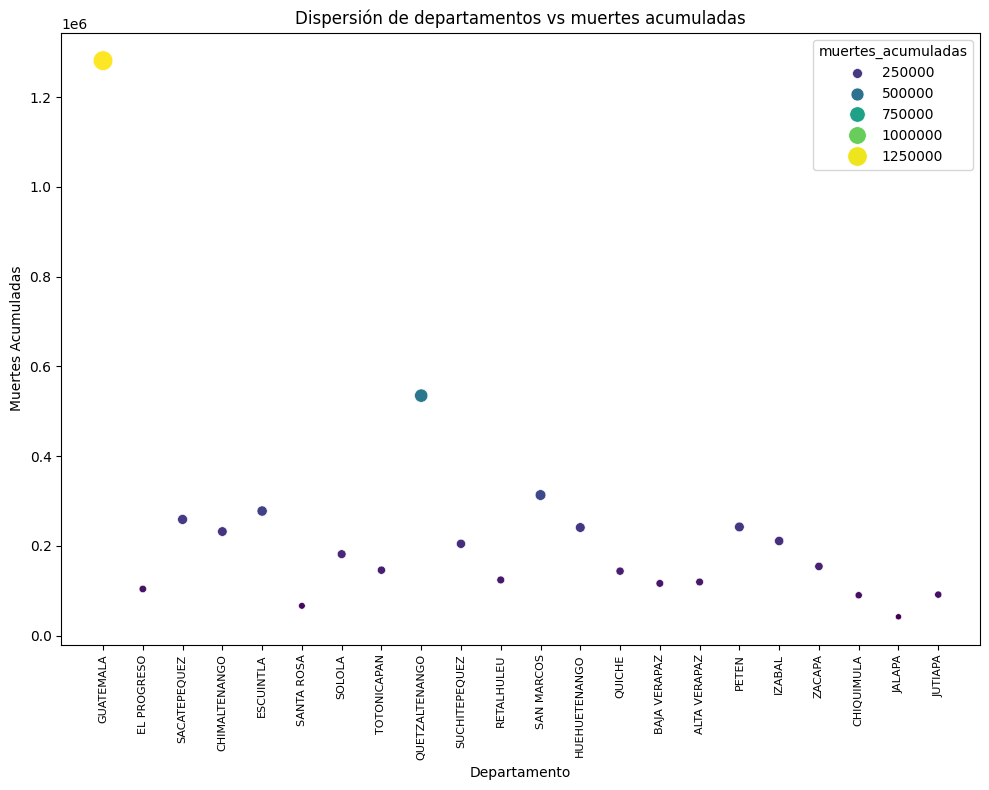

In [ ]:
# Crear gráfico de dispersión entre departamentos y muertes acumuladas
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='departamento', y='muertes_acumuladas', hue='muertes_acumuladas', palette='viridis', size='muertes_acumuladas', sizes=(20, 200))
plt.title("Dispersión de departamentos vs muertes acumuladas")
plt.xlabel("Departamento")
plt.ylabel("Muertes Acumuladas")
plt.xticks(rotation=90, fontsize=8)  # Cambiar tamaño de fuente de los departamentos
plt.tight_layout()
plt.show()

# OBSERVACIONES

* Concentración por municipio: Municipios como Guatemala, Mixco y Villa Nueva muestran una mayor cantidad de nuevas muertes, lo que los destaca como áreas prioritarias.
* Municipios con bajo impacto: Hay municipios con nuevas muertes cercanas a cero, que podrían indicar mejores condiciones o menor densidad poblacional.
* Distribución visual: Aunque existen municipios con valores elevados, la mayoría de los municipios tienen una dispersión más compacta hacia valores bajos.


### Conclusiones Relevantes

1. Municipios más afectados: Guatemala, Villa Nueva y Mixco son los municipios con mayor cantidad de nuevas muertes, por lo que deben ser priorizados para la asignación de recursos y estrategias de mitigación.
2. Desigualdad en el impacto: Existe una disparidad notable entre municipios, con unos pocos concentrando la mayoría de las nuevas muertes mientras que otros permanecen con cifras bajas.
3. Patrón de densidad poblacional: Los municipios con mayor población tienden a tener un mayor número de nuevas muertes, lo que resalta la necesidad de medidas específicas en áreas urbanas.
4. Análisis de buenas prácticas: Los municipios con bajas nuevas muertes podrían ser estudiados para replicar prácticas efectivas en otros municipios más afectados.
5. Planificación regional: Es necesario implementar estrategias diferenciadas por municipio, enfocándose en reducir las disparidades y brindando apoyo a los municipios más afectados.